In [1]:
from pathlib import Path
import os

import torch
import torch.nn as nn
from captum.attr import IntegratedGradients
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from models import TMeanNet, DepressionDetector, TAMFN
from datasets import get_dvlog_dataloader

os.environ["WANDB_NOTEBOOK_NAME"] = "attribution.ipynb" # temporary env variable
plt.style.use("ggplot")

/opt/homebrew/Caskroom/miniforge/base/envs/pytorchenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/pytorchenv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data

In [2]:
male_loader = get_dvlog_dataloader(
    "../dvlog-dataset/", "valid", batch_size=128, gender="m"
)
female_loader = get_dvlog_dataloader(
    "../dvlog-dataset/", "valid", batch_size=128, gender="f"
)
Xm, ym = next(iter(male_loader))
Xf, yf = next(iter(female_loader))

Xmd = Xm[ym==1]
Xfd = Xf[yf==1]
Xmn = Xm[ym==0]
Xfn = Xf[yf==0]
print(f"#male depressed: {Xmd.shape[0]}, #female depressed: {Xfd.shape[0]}")
print(f"#male undepressed: {Xmn.shape[0]}, #female undepressed: {Xfn.shape[0]}")
print(f"shape of Xmd: {Xmd.shape}, shape of Xfd: {Xfd.shape}")
print(f"shape of Xmu: {Xmn.shape}, shape of Xfu: {Xfn.shape}")

visual_features_idx = list(range(136))  
audio_features_idx = list(range(136, 161)) 

#male depressed: 21, #female depressed: 36
#male undepressed: 19, #female undepressed: 26
shape of Xmd: torch.Size([21, 1242, 161]), shape of Xfd: torch.Size([36, 1843, 161])
shape of Xmu: torch.Size([19, 1242, 161]), shape of Xfu: torch.Size([26, 1843, 161])


## 1. TMeanNet

In [3]:
model_path = Path("./artifacts/best_model:v25/")
if not model_path.exists():
    # download models from wandb website
    wandb.init()
    model_path = Path(wandb.use_artifact("allenyolk/dvlog/best_model:v25").download())
sd = torch.load(model_path / "best_model.pt", map_location="cpu")

net1 = TMeanNet(hidden_sizes=[512, 512, 512])
net1.load_state_dict(sd)

net1 = nn.Sequential(
    net1, 
    nn.Sigmoid()
)
net1.eval()

# attribution using Integrated Gradient Method
ig = IntegratedGradients(net1)

### a. Male Depressed

In [4]:
def ig_attribute(ig, input, n_steps=50):
    attributions, delta = ig.attribute(
        input, target=0, return_convergence_delta=True, n_steps=50
    )
    print(f"mean(delta)={delta.mean()}, lower abs is better!")

    attributions_avg_t = attributions.mean(dim=1)
    print(attributions_avg_t.shape)
    print(attributions_avg_t.abs().max())

    return pd.DataFrame(attributions_avg_t.numpy(), columns=[f'Feature_{i}' for i in range(161)])

data = ig_attribute(ig, Xmd)

mean(delta)=3.452893470886154e-05, lower abs is better!
torch.Size([21, 161])
tensor(0.0002, dtype=torch.float64)


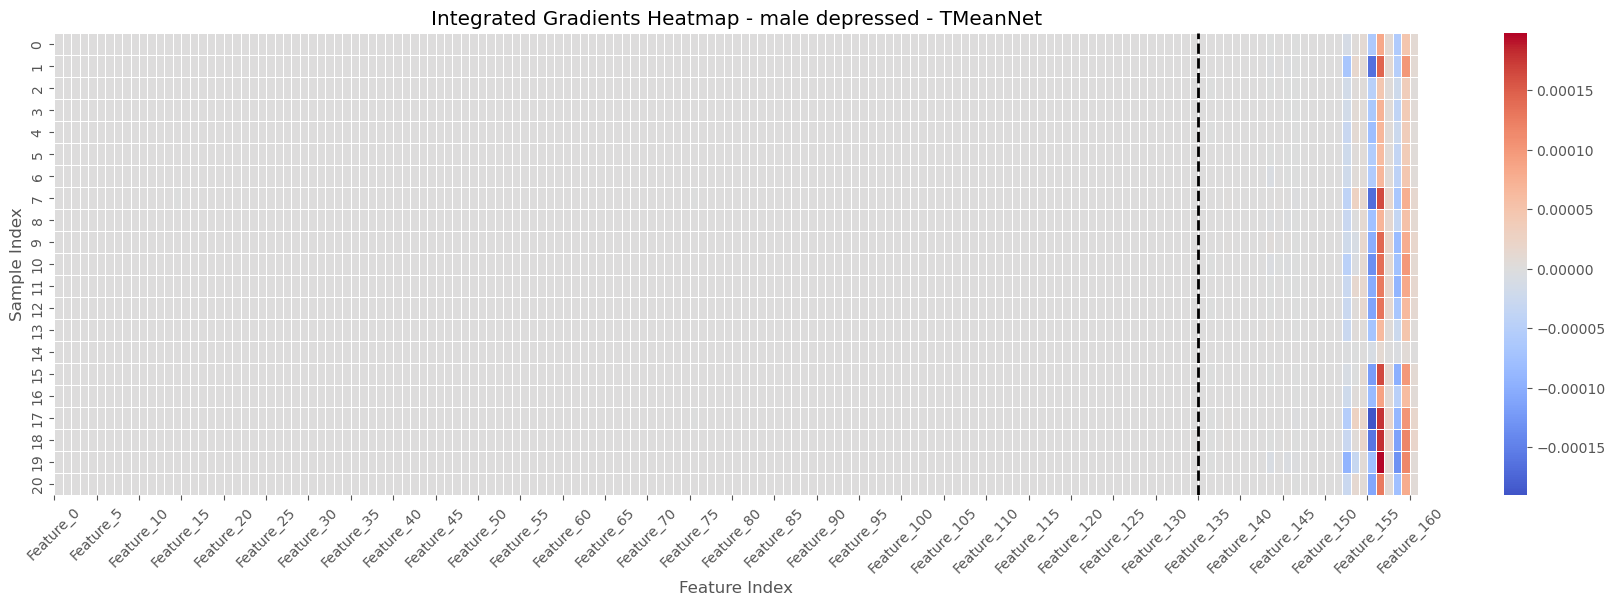

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_31994/3874884795.py:15: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


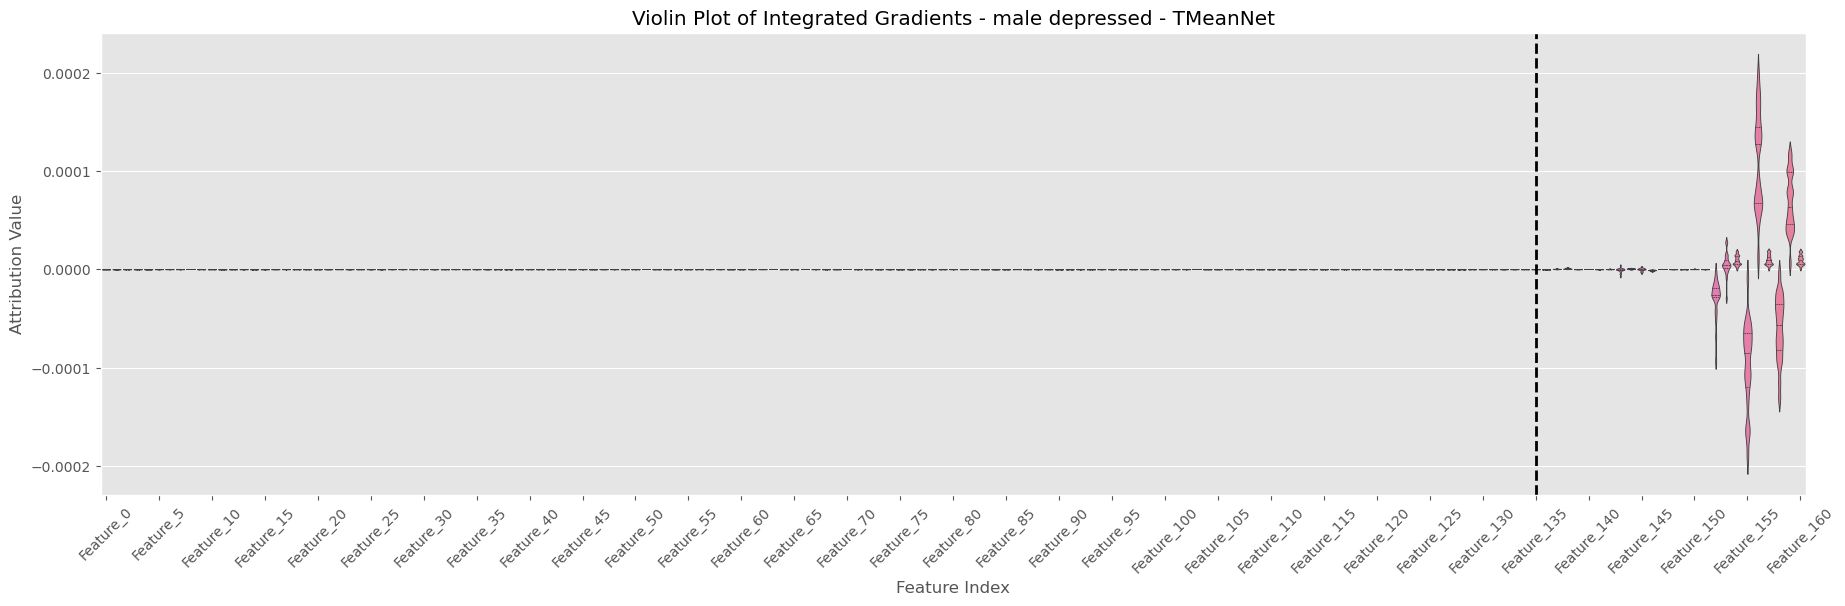

In [5]:
# 使用热力图显示平均归因值
def plot_heatmap(data, condition):
    plt.figure(figsize=(22, 6))
    sns.heatmap(data, cmap='coolwarm', linewidths=0.5, center=0.)
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.title(f'Integrated Gradients Heatmap - {condition}')
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)
    plt.xticks(range(0, 161, 5), data.columns[0:161:5], rotation=45)
    plt.show()

def plot_violin(data, condition):
    # 绘制小提琴图
    plt.figure(figsize=(22, 6))
    sns.violinplot(data=data, inner="quartile", bw=0.2)

    # 在小提琴图上添加标记以区分视觉特征和音频特征
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)

    plt.xlabel('Feature Index')
    plt.ylabel('Attribution Value')
    plt.xticks(range(0, 161, 5), rotation=45)
    plt.title(f'Violin Plot of Integrated Gradients - {condition}')
    plt.show()

plot_heatmap(data, "male depressed - TMeanNet")
plot_violin(data, "male depressed - TMeanNet")

### b. Female Depressed

mean(delta)=3.4821538273201874e-05, lower abs is better!
torch.Size([36, 161])
tensor(0.0002, dtype=torch.float64)


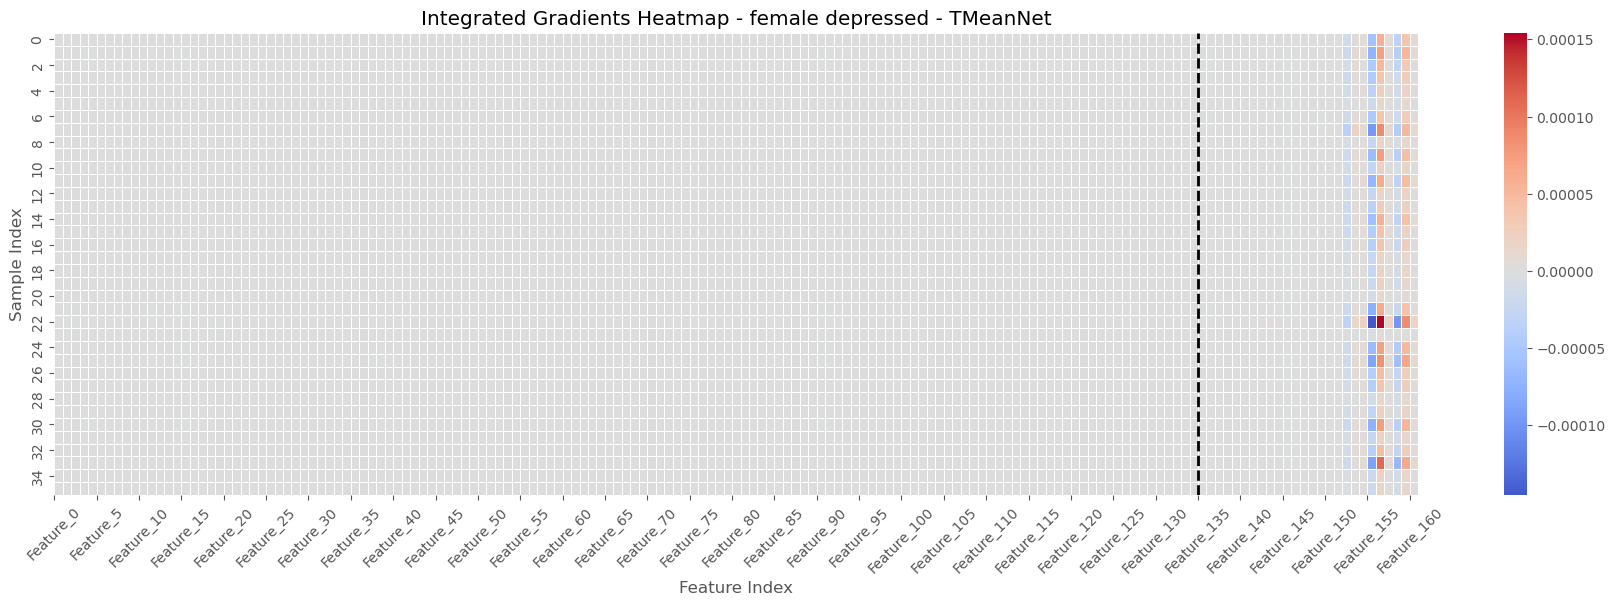

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_31994/3874884795.py:15: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


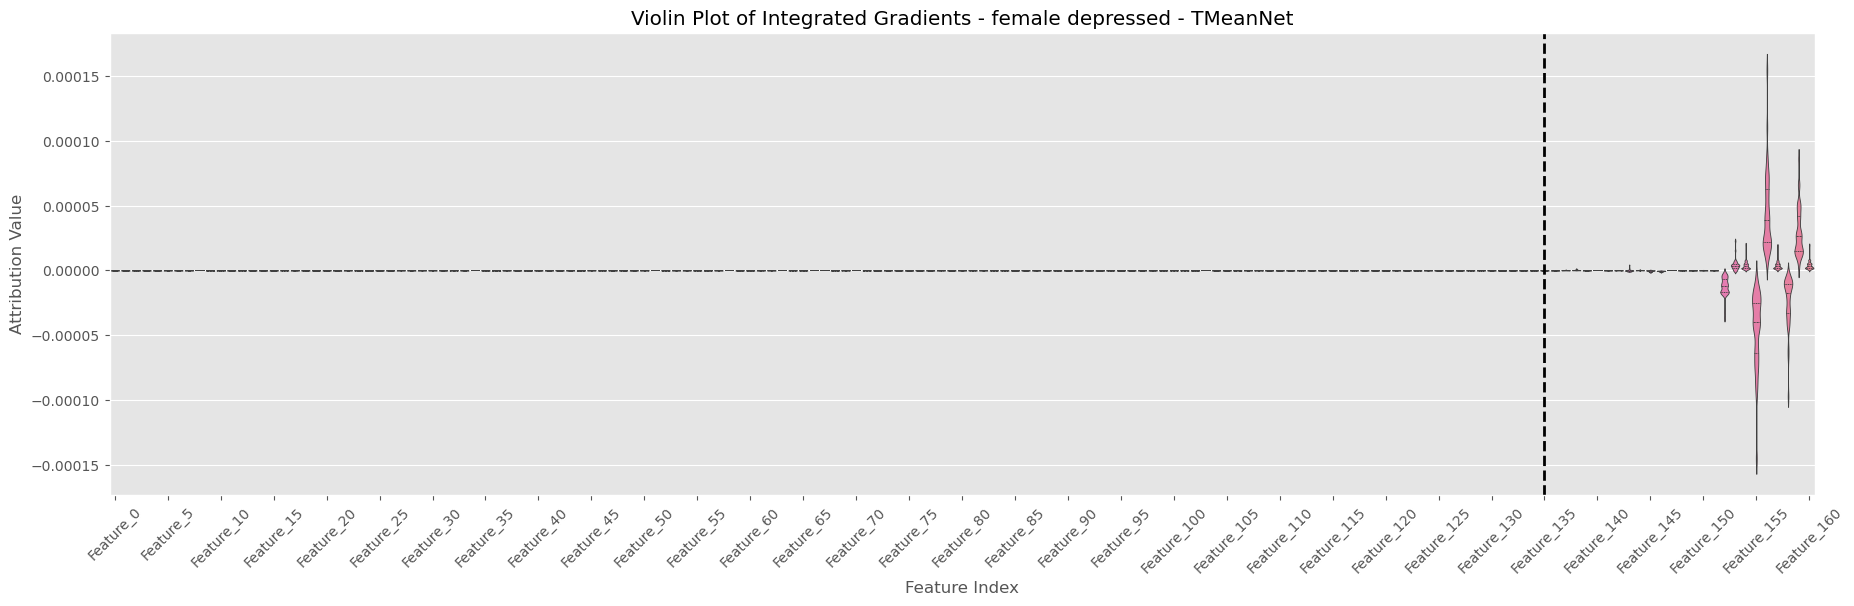

In [6]:
data = ig_attribute(ig, Xfd)
plot_heatmap(data, "female depressed - TMeanNet")
plot_violin(data, "female depressed - TMeanNet")

### c. Male Normal

mean(delta)=-1.5601482859915326e-05, lower abs is better!
torch.Size([19, 161])
tensor(0.0002, dtype=torch.float64)


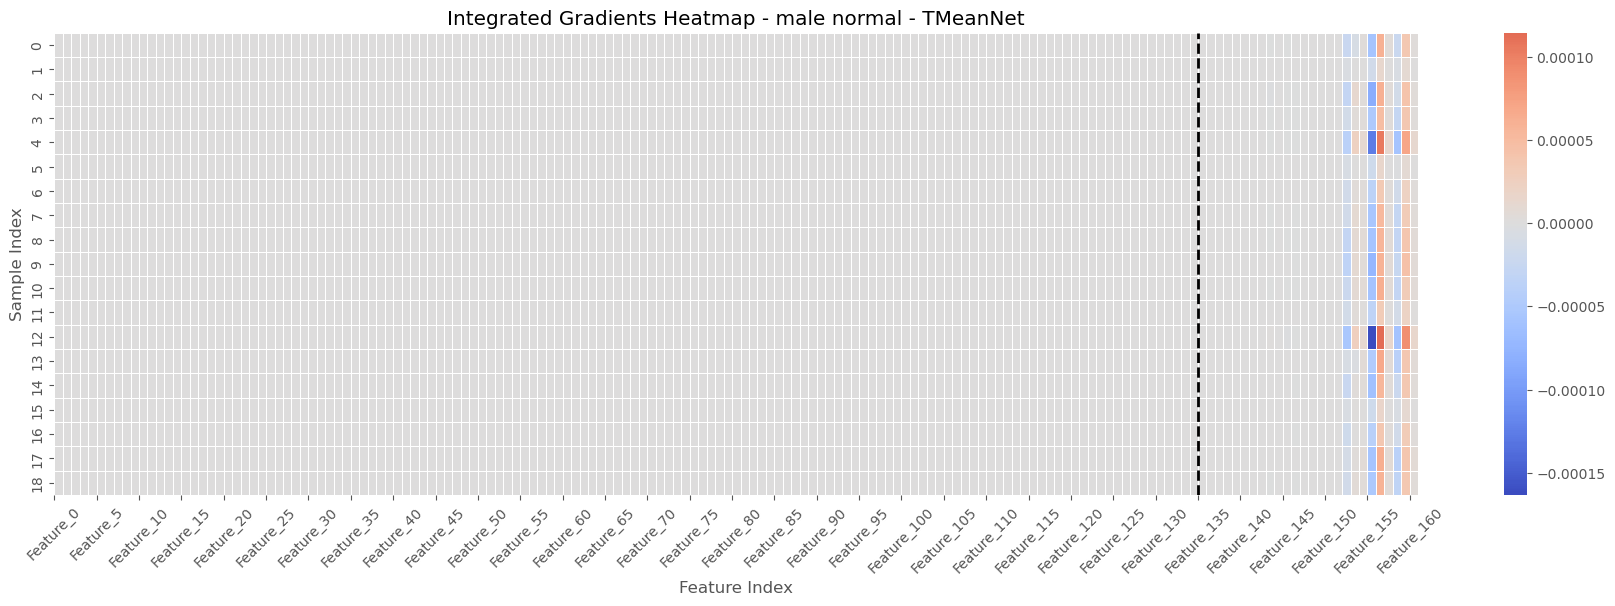

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_31994/3874884795.py:15: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


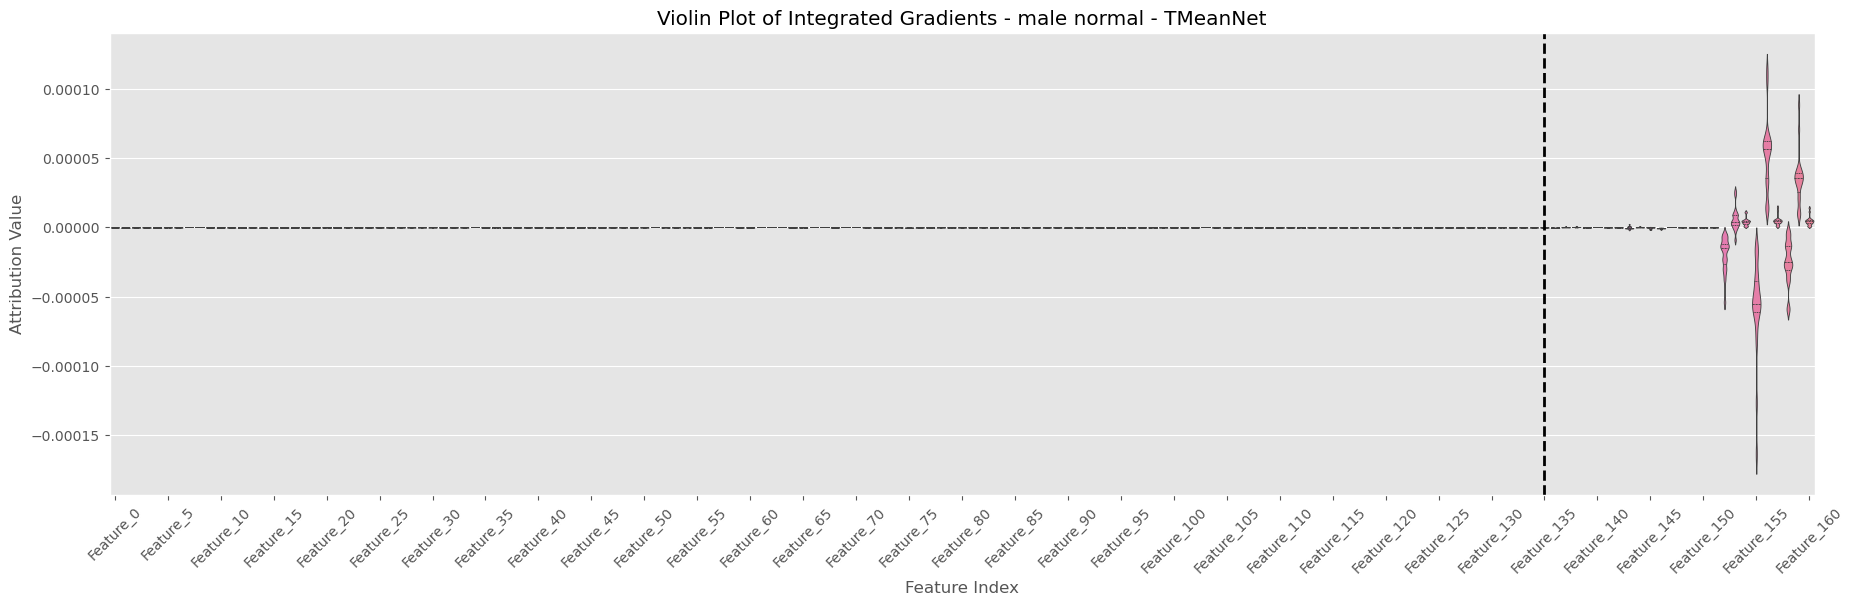

In [7]:
data = ig_attribute(ig, Xmn)
plot_heatmap(data, "male normal - TMeanNet")
plot_violin(data, "male normal - TMeanNet")

### d. Female Normal

mean(delta)=-1.0760099787253314e-05, lower abs is better!
torch.Size([26, 161])
tensor(0.0001, dtype=torch.float64)


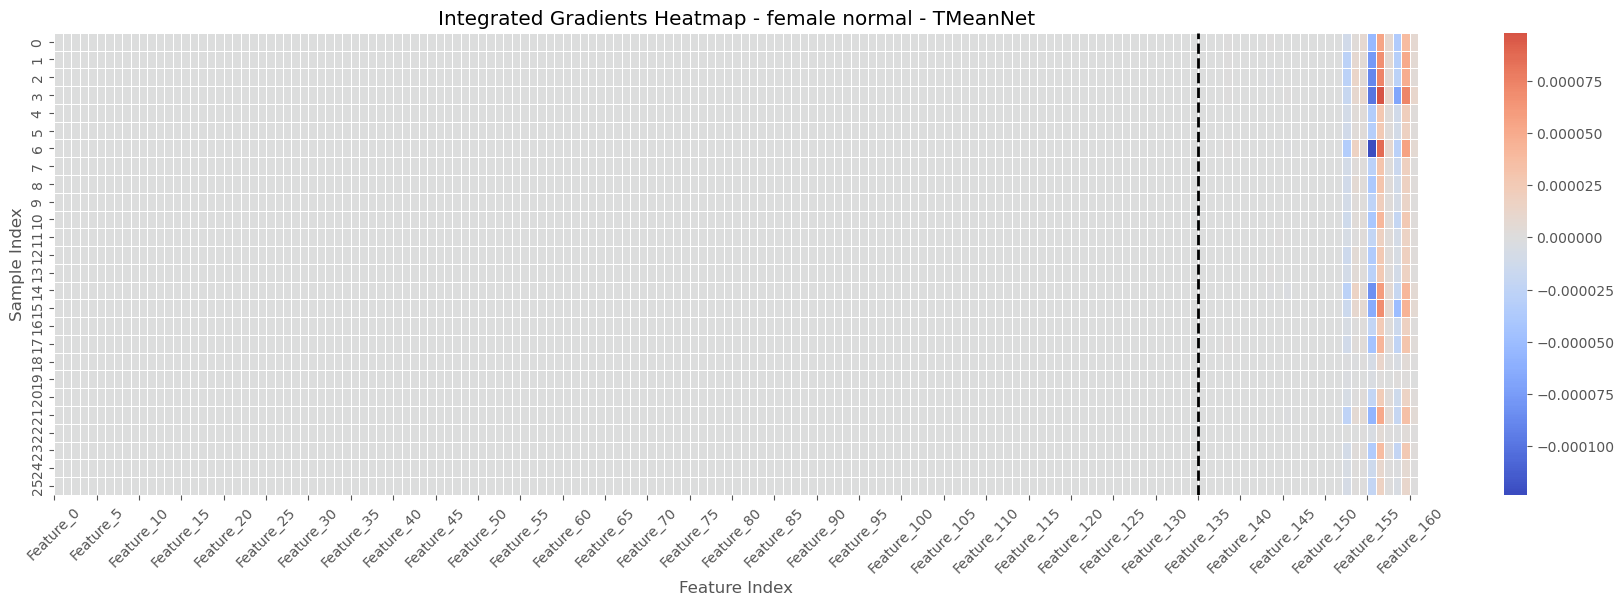

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_31994/3874884795.py:15: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


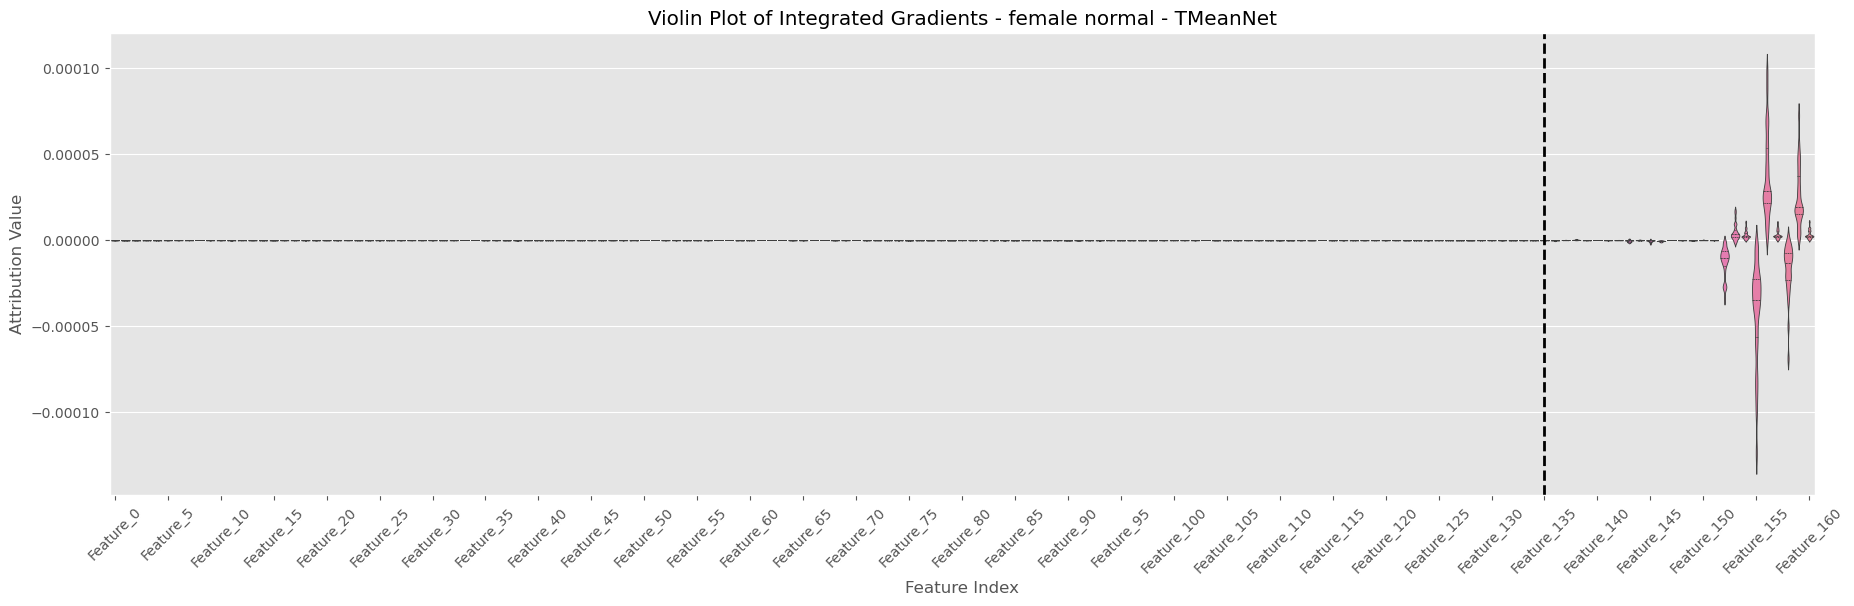

In [8]:
data = ig_attribute(ig, Xfn)
plot_heatmap(data, "female normal - TMeanNet")
plot_violin(data, "female normal - TMeanNet")

## 2. DepressionDetector

In [3]:
model_path = Path("./artifacts/best_model:v32/")
if not model_path.exists():
    # download models from wandb website
    wandb.init()
    model_path = Path(wandb.use_artifact("allenyolk/dvlog/best_model:v32").download())
sd = torch.load(model_path / "best_model.pt", map_location="cpu")

def process_state_dict(sd):
    new_sd = {}
    for k, v in sd.items():
        if k.startswith("module."):
            new_sd[k[7:]] = v
        else:
            new_sd[k] = v
    return new_sd

sd = process_state_dict(sd)

net2 = DepressionDetector(d=256, l=6, t_downsample=4)
net2.load_state_dict(sd)

net2 = nn.Sequential(
    net2, 
    nn.Sigmoid()
)
net2.eval()

# attribution using Integrated Gradient Method
ig = IntegratedGradients(net2)

In [4]:
def ig_attribute(ig, input, n_steps=50):
    attributions, delta = ig.attribute(
        input, target=0, return_convergence_delta=True, n_steps=50
    )
    print(f"mean(delta)={delta.mean()}, lower abs is better!")

    attributions_avg_t = attributions.mean(dim=1)
    print(attributions_avg_t.shape)
    print(attributions_avg_t.abs().max())

    return pd.DataFrame(attributions_avg_t.numpy(), columns=[f'Feature_{i}' for i in range(161)])

# 使用热力图显示平均归因值
def plot_heatmap(data, condition):
    plt.figure(figsize=(22, 6))
    sns.heatmap(data, cmap='coolwarm', linewidths=0.5, center=0.)
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.title(f'Integrated Gradients Heatmap - {condition}')
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)
    plt.xticks(range(0, 161, 5), data.columns[0:161:5], rotation=45)
    plt.show()

def plot_violin(data, condition):
    # 绘制小提琴图
    plt.figure(figsize=(22, 6))
    sns.violinplot(data=data, inner="quartile", bw=0.2)

    # 在小提琴图上添加标记以区分视觉特征和音频特征
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)

    plt.xlabel('Feature Index')
    plt.ylabel('Attribution Value')
    plt.xticks(range(0, 161, 5), rotation=45)
    plt.title(f'Violin Plot of Integrated Gradients - {condition}')
    plt.show()

### a. Male Depressed

In [5]:
data = ig_attribute(ig, Xmd, n_steps=10)
plot_heatmap(data, "male depressed - DepressionDetector")
plot_violin(data, "male depressed - DepressionDetector")

: 

### b. Female Depressed

mean(delta)=0.29900132710702215, lower abs is better!
torch.Size([36, 161])
tensor(0.0023, dtype=torch.float64)


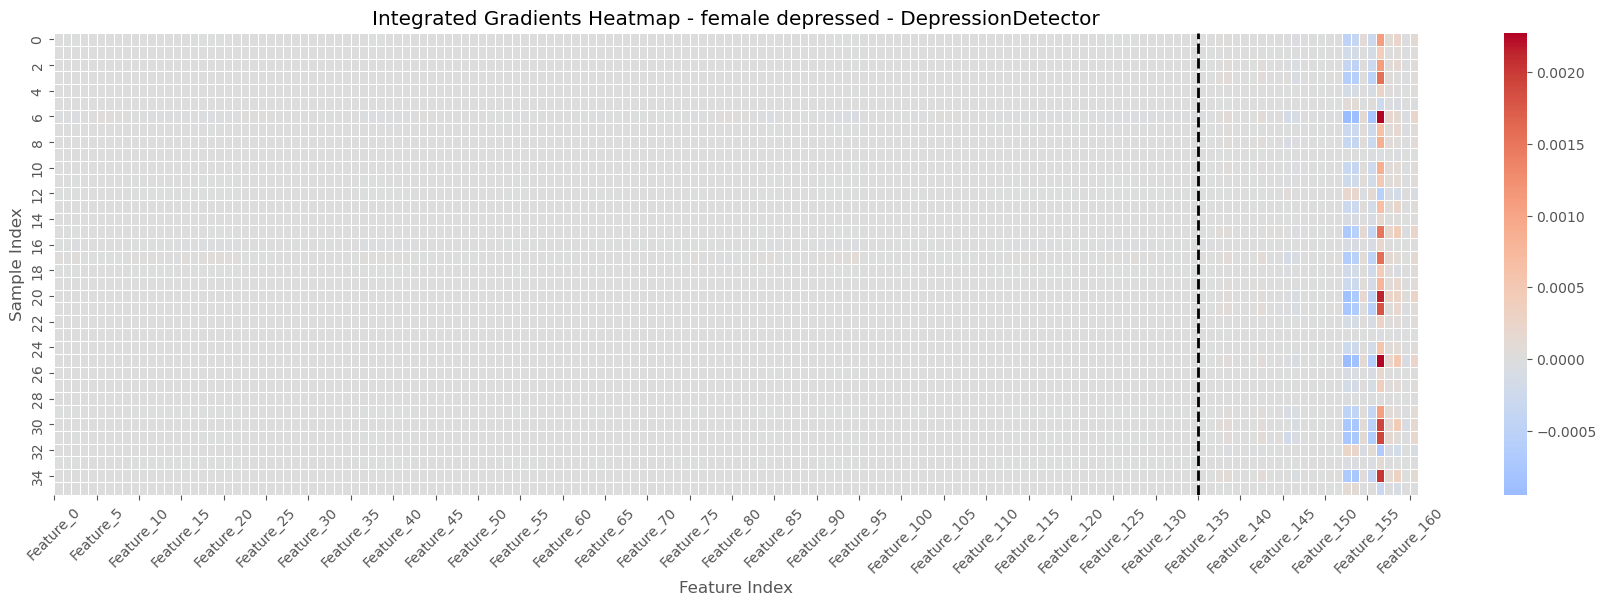

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_20377/3874884795.py:15: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


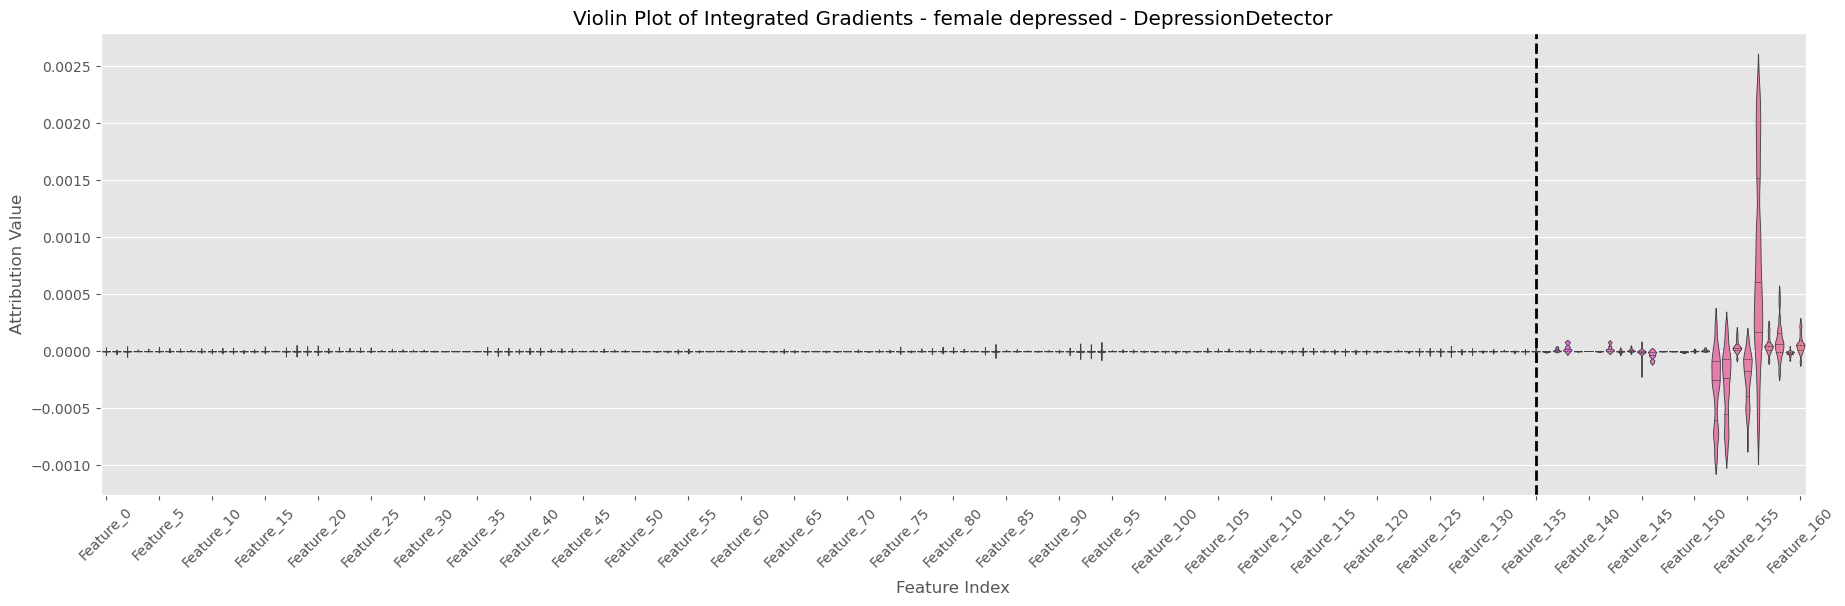

In [ ]:
data = ig_attribute(ig, Xfd, n_steps=10)
plot_heatmap(data, "female depressed - DepressionDetector")
plot_violin(data, "female depressed - DepressionDetector")

### c. Male Normal

In [ ]:
data = ig_attribute(ig, Xmn, n_steps=10)
plot_heatmap(data, "male normal - DepressionDetector")
plot_violin(data, "male normal - DepressionDetector")

TypeError: ig_attribute() got an unexpected keyword argument 'n_steps'

### d. Femal Normal

In [ ]:
data = ig_attribute(ig, Xfn, n_steps=10)
plot_heatmap(data, "female normal - DepressionDetector")
plot_violin(data, "female normal - DepressionDetector")

## 3. TAMFN

In [ ]:
model_path = Path("./artifacts/best_model:v37/")
if not model_path.exists():
    # download models from wandb website
    wandb.init()
    model_path = Path(wandb.use_artifact("allenyolk/dvlog/best_model:v37").download())
sd = torch.load(model_path / "best_model.pt", map_location="cpu")
sd = process_state_dict(sd)

net3 = TAMFN(d=256, l=6, t_downsample=4)
net3.load_state_dict(sd)

net3 = nn.Sequential(
    net3, 
    nn.Sigmoid()
)
net3.eval()

# attribution using Integrated Gradient Method
ig = IntegratedGradients(net3)

wandb: Downloading large artifact best_model:v37, 78.11MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:7.4


RuntimeError: Error(s) in loading state_dict for TAMFN:
	Missing key(s) in state_dict: "v_downsample.0.weight", "v_downsample.0.bias", "v_downsample.1.weight", "v_downsample.1.bias", "v_downsample.1.running_mean", "v_downsample.1.running_var", "a_downsample.0.weight", "a_downsample.0.bias", "a_downsample.1.weight", "a_downsample.1.bias", "a_downsample.1.running_mean", "a_downsample.1.running_var", "gtcn_a.0.branch1.0.weight", "gtcn_a.0.branch1.0.bias", "gtcn_a.0.branch1.1.weight", "gtcn_a.0.branch1.1.bias", "gtcn_a.0.branch1.1.running_mean", "gtcn_a.0.branch1.1.running_var", "gtcn_a.0.branch1.3.weight", "gtcn_a.0.branch1.3.bias", "gtcn_a.0.branch1.4.weight", "gtcn_a.0.branch1.4.bias", "gtcn_a.0.branch1.4.running_mean", "gtcn_a.0.branch1.4.running_var", "gtcn_a.0.branch2.1.weight", "gtcn_a.0.branch2.1.bias", "gtcn_a.0.branch2.2.weight", "gtcn_a.0.branch2.2.bias", "gtcn_a.0.branch2.2.running_mean", "gtcn_a.0.branch2.2.running_var", "gtcn_a.0.branch2.4.weight", "gtcn_a.0.branch2.4.bias", "gtcn_a.0.branch2.5.weight", "gtcn_a.0.branch2.5.bias", "gtcn_a.0.branch2.5.running_mean", "gtcn_a.0.branch2.5.running_var", "gtcn_a.1.branch1.0.weight", "gtcn_a.1.branch1.0.bias", "gtcn_a.1.branch1.1.weight", "gtcn_a.1.branch1.1.bias", "gtcn_a.1.branch1.1.running_mean", "gtcn_a.1.branch1.1.running_var", "gtcn_a.1.branch1.3.weight", "gtcn_a.1.branch1.3.bias", "gtcn_a.1.branch1.4.weight", "gtcn_a.1.branch1.4.bias", "gtcn_a.1.branch1.4.running_mean", "gtcn_a.1.branch1.4.running_var", "gtcn_a.1.branch2.1.weight", "gtcn_a.1.branch2.1.bias", "gtcn_a.1.branch2.2.weight", "gtcn_a.1.branch2.2.bias", "gtcn_a.1.branch2.2.running_mean", "gtcn_a.1.branch2.2.running_var", "gtcn_a.1.branch2.4.weight", "gtcn_a.1.branch2.4.bias", "gtcn_a.1.branch2.5.weight", "gtcn_a.1.branch2.5.bias", "gtcn_a.1.branch2.5.running_mean", "gtcn_a.1.branch2.5.running_var", "gtcn_a.2.branch1.0.weight", "gtcn_a.2.branch1.0.bias", "gtcn_a.2.branch1.1.weight", "gtcn_a.2.branch1.1.bias", "gtcn_a.2.branch1.1.running_mean", "gtcn_a.2.branch1.1.running_var", "gtcn_a.2.branch1.3.weight", "gtcn_a.2.branch1.3.bias", "gtcn_a.2.branch1.4.weight", "gtcn_a.2.branch1.4.bias", "gtcn_a.2.branch1.4.running_mean", "gtcn_a.2.branch1.4.running_var", "gtcn_a.2.branch2.1.weight", "gtcn_a.2.branch2.1.bias", "gtcn_a.2.branch2.2.weight", "gtcn_a.2.branch2.2.bias", "gtcn_a.2.branch2.2.running_mean", "gtcn_a.2.branch2.2.running_var", "gtcn_a.2.branch2.4.weight", "gtcn_a.2.branch2.4.bias", "gtcn_a.2.branch2.5.weight", "gtcn_a.2.branch2.5.bias", "gtcn_a.2.branch2.5.running_mean", "gtcn_a.2.branch2.5.running_var", "gtcn_a.3.branch1.0.weight", "gtcn_a.3.branch1.0.bias", "gtcn_a.3.branch1.1.weight", "gtcn_a.3.branch1.1.bias", "gtcn_a.3.branch1.1.running_mean", "gtcn_a.3.branch1.1.running_var", "gtcn_a.3.branch1.3.weight", "gtcn_a.3.branch1.3.bias", "gtcn_a.3.branch1.4.weight", "gtcn_a.3.branch1.4.bias", "gtcn_a.3.branch1.4.running_mean", "gtcn_a.3.branch1.4.running_var", "gtcn_a.3.branch2.1.weight", "gtcn_a.3.branch2.1.bias", "gtcn_a.3.branch2.2.weight", "gtcn_a.3.branch2.2.bias", "gtcn_a.3.branch2.2.running_mean", "gtcn_a.3.branch2.2.running_var", "gtcn_a.3.branch2.4.weight", "gtcn_a.3.branch2.4.bias", "gtcn_a.3.branch2.5.weight", "gtcn_a.3.branch2.5.bias", "gtcn_a.3.branch2.5.running_mean", "gtcn_a.3.branch2.5.running_var", "gtcn_a.4.branch1.0.weight", "gtcn_a.4.branch1.0.bias", "gtcn_a.4.branch1.1.weight", "gtcn_a.4.branch1.1.bias", "gtcn_a.4.branch1.1.running_mean", "gtcn_a.4.branch1.1.running_var", "gtcn_a.4.branch1.3.weight", "gtcn_a.4.branch1.3.bias", "gtcn_a.4.branch1.4.weight", "gtcn_a.4.branch1.4.bias", "gtcn_a.4.branch1.4.running_mean", "gtcn_a.4.branch1.4.running_var", "gtcn_a.4.branch2.1.weight", "gtcn_a.4.branch2.1.bias", "gtcn_a.4.branch2.2.weight", "gtcn_a.4.branch2.2.bias", "gtcn_a.4.branch2.2.running_mean", "gtcn_a.4.branch2.2.running_var", "gtcn_a.4.branch2.4.weight", "gtcn_a.4.branch2.4.bias", "gtcn_a.4.branch2.5.weight", "gtcn_a.4.branch2.5.bias", "gtcn_a.4.branch2.5.running_mean", "gtcn_a.4.branch2.5.running_var", "gtcn_a.5.branch1.0.weight", "gtcn_a.5.branch1.0.bias", "gtcn_a.5.branch1.1.weight", "gtcn_a.5.branch1.1.bias", "gtcn_a.5.branch1.1.running_mean", "gtcn_a.5.branch1.1.running_var", "gtcn_a.5.branch1.3.weight", "gtcn_a.5.branch1.3.bias", "gtcn_a.5.branch1.4.weight", "gtcn_a.5.branch1.4.bias", "gtcn_a.5.branch1.4.running_mean", "gtcn_a.5.branch1.4.running_var", "gtcn_a.5.branch2.1.weight", "gtcn_a.5.branch2.1.bias", "gtcn_a.5.branch2.2.weight", "gtcn_a.5.branch2.2.bias", "gtcn_a.5.branch2.2.running_mean", "gtcn_a.5.branch2.2.running_var", "gtcn_a.5.branch2.4.weight", "gtcn_a.5.branch2.4.bias", "gtcn_a.5.branch2.5.weight", "gtcn_a.5.branch2.5.bias", "gtcn_a.5.branch2.5.running_mean", "gtcn_a.5.branch2.5.running_var", "gtcn_v.0.branch1.0.weight", "gtcn_v.0.branch1.0.bias", "gtcn_v.0.branch1.1.weight", "gtcn_v.0.branch1.1.bias", "gtcn_v.0.branch1.1.running_mean", "gtcn_v.0.branch1.1.running_var", "gtcn_v.0.branch1.3.weight", "gtcn_v.0.branch1.3.bias", "gtcn_v.0.branch1.4.weight", "gtcn_v.0.branch1.4.bias", "gtcn_v.0.branch1.4.running_mean", "gtcn_v.0.branch1.4.running_var", "gtcn_v.0.branch2.1.weight", "gtcn_v.0.branch2.1.bias", "gtcn_v.0.branch2.2.weight", "gtcn_v.0.branch2.2.bias", "gtcn_v.0.branch2.2.running_mean", "gtcn_v.0.branch2.2.running_var", "gtcn_v.0.branch2.4.weight", "gtcn_v.0.branch2.4.bias", "gtcn_v.0.branch2.5.weight", "gtcn_v.0.branch2.5.bias", "gtcn_v.0.branch2.5.running_mean", "gtcn_v.0.branch2.5.running_var", "gtcn_v.1.branch1.0.weight", "gtcn_v.1.branch1.0.bias", "gtcn_v.1.branch1.1.weight", "gtcn_v.1.branch1.1.bias", "gtcn_v.1.branch1.1.running_mean", "gtcn_v.1.branch1.1.running_var", "gtcn_v.1.branch1.3.weight", "gtcn_v.1.branch1.3.bias", "gtcn_v.1.branch1.4.weight", "gtcn_v.1.branch1.4.bias", "gtcn_v.1.branch1.4.running_mean", "gtcn_v.1.branch1.4.running_var", "gtcn_v.1.branch2.1.weight", "gtcn_v.1.branch2.1.bias", "gtcn_v.1.branch2.2.weight", "gtcn_v.1.branch2.2.bias", "gtcn_v.1.branch2.2.running_mean", "gtcn_v.1.branch2.2.running_var", "gtcn_v.1.branch2.4.weight", "gtcn_v.1.branch2.4.bias", "gtcn_v.1.branch2.5.weight", "gtcn_v.1.branch2.5.bias", "gtcn_v.1.branch2.5.running_mean", "gtcn_v.1.branch2.5.running_var", "gtcn_v.2.branch1.0.weight", "gtcn_v.2.branch1.0.bias", "gtcn_v.2.branch1.1.weight", "gtcn_v.2.branch1.1.bias", "gtcn_v.2.branch1.1.running_mean", "gtcn_v.2.branch1.1.running_var", "gtcn_v.2.branch1.3.weight", "gtcn_v.2.branch1.3.bias", "gtcn_v.2.branch1.4.weight", "gtcn_v.2.branch1.4.bias", "gtcn_v.2.branch1.4.running_mean", "gtcn_v.2.branch1.4.running_var", "gtcn_v.2.branch2.1.weight", "gtcn_v.2.branch2.1.bias", "gtcn_v.2.branch2.2.weight", "gtcn_v.2.branch2.2.bias", "gtcn_v.2.branch2.2.running_mean", "gtcn_v.2.branch2.2.running_var", "gtcn_v.2.branch2.4.weight", "gtcn_v.2.branch2.4.bias", "gtcn_v.2.branch2.5.weight", "gtcn_v.2.branch2.5.bias", "gtcn_v.2.branch2.5.running_mean", "gtcn_v.2.branch2.5.running_var", "gtcn_v.3.branch1.0.weight", "gtcn_v.3.branch1.0.bias", "gtcn_v.3.branch1.1.weight", "gtcn_v.3.branch1.1.bias", "gtcn_v.3.branch1.1.running_mean", "gtcn_v.3.branch1.1.running_var", "gtcn_v.3.branch1.3.weight", "gtcn_v.3.branch1.3.bias", "gtcn_v.3.branch1.4.weight", "gtcn_v.3.branch1.4.bias", "gtcn_v.3.branch1.4.running_mean", "gtcn_v.3.branch1.4.running_var", "gtcn_v.3.branch2.1.weight", "gtcn_v.3.branch2.1.bias", "gtcn_v.3.branch2.2.weight", "gtcn_v.3.branch2.2.bias", "gtcn_v.3.branch2.2.running_mean", "gtcn_v.3.branch2.2.running_var", "gtcn_v.3.branch2.4.weight", "gtcn_v.3.branch2.4.bias", "gtcn_v.3.branch2.5.weight", "gtcn_v.3.branch2.5.bias", "gtcn_v.3.branch2.5.running_mean", "gtcn_v.3.branch2.5.running_var", "gtcn_v.4.branch1.0.weight", "gtcn_v.4.branch1.0.bias", "gtcn_v.4.branch1.1.weight", "gtcn_v.4.branch1.1.bias", "gtcn_v.4.branch1.1.running_mean", "gtcn_v.4.branch1.1.running_var", "gtcn_v.4.branch1.3.weight", "gtcn_v.4.branch1.3.bias", "gtcn_v.4.branch1.4.weight", "gtcn_v.4.branch1.4.bias", "gtcn_v.4.branch1.4.running_mean", "gtcn_v.4.branch1.4.running_var", "gtcn_v.4.branch2.1.weight", "gtcn_v.4.branch2.1.bias", "gtcn_v.4.branch2.2.weight", "gtcn_v.4.branch2.2.bias", "gtcn_v.4.branch2.2.running_mean", "gtcn_v.4.branch2.2.running_var", "gtcn_v.4.branch2.4.weight", "gtcn_v.4.branch2.4.bias", "gtcn_v.4.branch2.5.weight", "gtcn_v.4.branch2.5.bias", "gtcn_v.4.branch2.5.running_mean", "gtcn_v.4.branch2.5.running_var", "gtcn_v.5.branch1.0.weight", "gtcn_v.5.branch1.0.bias", "gtcn_v.5.branch1.1.weight", "gtcn_v.5.branch1.1.bias", "gtcn_v.5.branch1.1.running_mean", "gtcn_v.5.branch1.1.running_var", "gtcn_v.5.branch1.3.weight", "gtcn_v.5.branch1.3.bias", "gtcn_v.5.branch1.4.weight", "gtcn_v.5.branch1.4.bias", "gtcn_v.5.branch1.4.running_mean", "gtcn_v.5.branch1.4.running_var", "gtcn_v.5.branch2.1.weight", "gtcn_v.5.branch2.1.bias", "gtcn_v.5.branch2.2.weight", "gtcn_v.5.branch2.2.bias", "gtcn_v.5.branch2.2.running_mean", "gtcn_v.5.branch2.2.running_var", "gtcn_v.5.branch2.4.weight", "gtcn_v.5.branch2.4.bias", "gtcn_v.5.branch2.5.weight", "gtcn_v.5.branch2.5.bias", "gtcn_v.5.branch2.5.running_mean", "gtcn_v.5.branch2.5.running_var", "ife.0.branch1.0.weight", "ife.0.branch1.0.bias", "ife.0.branch1.1.weight", "ife.0.branch1.1.bias", "ife.0.branch1.1.running_mean", "ife.0.branch1.1.running_var", "ife.0.branch1.3.weight", "ife.0.branch1.3.bias", "ife.0.branch1.4.weight", "ife.0.branch1.4.bias", "ife.0.branch1.4.running_mean", "ife.0.branch1.4.running_var", "ife.0.branch2.1.weight", "ife.0.branch2.1.bias", "ife.0.branch2.2.weight", "ife.0.branch2.2.bias", "ife.0.branch2.2.running_mean", "ife.0.branch2.2.running_var", "ife.0.branch2.4.weight", "ife.0.branch2.4.bias", "ife.0.branch2.5.weight", "ife.0.branch2.5.bias", "ife.0.branch2.5.running_mean", "ife.0.branch2.5.running_var", "ife.1.branch1.0.weight", "ife.1.branch1.0.bias", "ife.1.branch1.1.weight", "ife.1.branch1.1.bias", "ife.1.branch1.1.running_mean", "ife.1.branch1.1.running_var", "ife.1.branch1.3.weight", "ife.1.branch1.3.bias", "ife.1.branch1.4.weight", "ife.1.branch1.4.bias", "ife.1.branch1.4.running_mean", "ife.1.branch1.4.running_var", "ife.1.branch2.1.weight", "ife.1.branch2.1.bias", "ife.1.branch2.2.weight", "ife.1.branch2.2.bias", "ife.1.branch2.2.running_mean", "ife.1.branch2.2.running_var", "ife.1.branch2.4.weight", "ife.1.branch2.4.bias", "ife.1.branch2.5.weight", "ife.1.branch2.5.bias", "ife.1.branch2.5.running_mean", "ife.1.branch2.5.running_var", "ife.2.branch1.0.weight", "ife.2.branch1.0.bias", "ife.2.branch1.1.weight", "ife.2.branch1.1.bias", "ife.2.branch1.1.running_mean", "ife.2.branch1.1.running_var", "ife.2.branch1.3.weight", "ife.2.branch1.3.bias", "ife.2.branch1.4.weight", "ife.2.branch1.4.bias", "ife.2.branch1.4.running_mean", "ife.2.branch1.4.running_var", "ife.2.branch2.1.weight", "ife.2.branch2.1.bias", "ife.2.branch2.2.weight", "ife.2.branch2.2.bias", "ife.2.branch2.2.running_mean", "ife.2.branch2.2.running_var", "ife.2.branch2.4.weight", "ife.2.branch2.4.bias", "ife.2.branch2.5.weight", "ife.2.branch2.5.bias", "ife.2.branch2.5.running_mean", "ife.2.branch2.5.running_var", "ife.3.branch1.0.weight", "ife.3.branch1.0.bias", "ife.3.branch1.1.weight", "ife.3.branch1.1.bias", "ife.3.branch1.1.running_mean", "ife.3.branch1.1.running_var", "ife.3.branch1.3.weight", "ife.3.branch1.3.bias", "ife.3.branch1.4.weight", "ife.3.branch1.4.bias", "ife.3.branch1.4.running_mean", "ife.3.branch1.4.running_var", "ife.3.branch2.1.weight", "ife.3.branch2.1.bias", "ife.3.branch2.2.weight", "ife.3.branch2.2.bias", "ife.3.branch2.2.running_mean", "ife.3.branch2.2.running_var", "ife.3.branch2.4.weight", "ife.3.branch2.4.bias", "ife.3.branch2.5.weight", "ife.3.branch2.5.bias", "ife.3.branch2.5.running_mean", "ife.3.branch2.5.running_var", "ife.4.branch1.0.weight", "ife.4.branch1.0.bias", "ife.4.branch1.1.weight", "ife.4.branch1.1.bias", "ife.4.branch1.1.running_mean", "ife.4.branch1.1.running_var", "ife.4.branch1.3.weight", "ife.4.branch1.3.bias", "ife.4.branch1.4.weight", "ife.4.branch1.4.bias", "ife.4.branch1.4.running_mean", "ife.4.branch1.4.running_var", "ife.4.branch2.1.weight", "ife.4.branch2.1.bias", "ife.4.branch2.2.weight", "ife.4.branch2.2.bias", "ife.4.branch2.2.running_mean", "ife.4.branch2.2.running_var", "ife.4.branch2.4.weight", "ife.4.branch2.4.bias", "ife.4.branch2.5.weight", "ife.4.branch2.5.bias", "ife.4.branch2.5.running_mean", "ife.4.branch2.5.running_var", "ife.5.branch1.0.weight", "ife.5.branch1.0.bias", "ife.5.branch1.1.weight", "ife.5.branch1.1.bias", "ife.5.branch1.1.running_mean", "ife.5.branch1.1.running_var", "ife.5.branch1.3.weight", "ife.5.branch1.3.bias", "ife.5.branch1.4.weight", "ife.5.branch1.4.bias", "ife.5.branch1.4.running_mean", "ife.5.branch1.4.running_var", "ife.5.branch2.1.weight", "ife.5.branch2.1.bias", "ife.5.branch2.2.weight", "ife.5.branch2.2.bias", "ife.5.branch2.2.running_mean", "ife.5.branch2.2.running_var", "ife.5.branch2.4.weight", "ife.5.branch2.4.bias", "ife.5.branch2.5.weight", "ife.5.branch2.5.bias", "ife.5.branch2.5.running_mean", "ife.5.branch2.5.running_var", "tamf_av.lstm1.weight_ih_l0", "tamf_av.lstm1.weight_hh_l0", "tamf_av.lstm1.bias_ih_l0", "tamf_av.lstm1.bias_hh_l0", "tamf_av.lstm2.weight_ih_l0", "tamf_av.lstm2.weight_hh_l0", "tamf_av.lstm2.bias_ih_l0", "tamf_av.lstm2.bias_hh_l0", "tamf_av.proj_v.weight", "tamf_av.proj_v.bias", "tamf_av.proj_h1.weight_ih_l0", "tamf_av.proj_h1.weight_hh_l0", "tamf_av.proj_h1.bias_ih_l0", "tamf_av.proj_h1.bias_hh_l0", "tamf_av.proj_h1.weight_ih_l0_reverse", "tamf_av.proj_h1.weight_hh_l0_reverse", "tamf_av.proj_h1.bias_ih_l0_reverse", "tamf_av.proj_h1.bias_hh_l0_reverse", "tamf_av.proj_h2.weight", "tamf_av.proj_h2.bias", "tamf_af.lstm1.weight_ih_l0", "tamf_af.lstm1.weight_hh_l0", "tamf_af.lstm1.bias_ih_l0", "tamf_af.lstm1.bias_hh_l0", "tamf_af.lstm2.weight_ih_l0", "tamf_af.lstm2.weight_hh_l0", "tamf_af.lstm2.bias_ih_l0", "tamf_af.lstm2.bias_hh_l0", "tamf_af.proj_v.weight", "tamf_af.proj_v.bias", "tamf_af.proj_h1.weight_ih_l0", "tamf_af.proj_h1.weight_hh_l0", "tamf_af.proj_h1.bias_ih_l0", "tamf_af.proj_h1.bias_hh_l0", "tamf_af.proj_h1.weight_ih_l0_reverse", "tamf_af.proj_h1.weight_hh_l0_reverse", "tamf_af.proj_h1.bias_ih_l0_reverse", "tamf_af.proj_h1.bias_hh_l0_reverse", "tamf_af.proj_h2.weight", "tamf_af.proj_h2.bias", "tamf_fv.lstm1.weight_ih_l0", "tamf_fv.lstm1.weight_hh_l0", "tamf_fv.lstm1.bias_ih_l0", "tamf_fv.lstm1.bias_hh_l0", "tamf_fv.lstm2.weight_ih_l0", "tamf_fv.lstm2.weight_hh_l0", "tamf_fv.lstm2.bias_ih_l0", "tamf_fv.lstm2.bias_hh_l0", "tamf_fv.proj_v.weight", "tamf_fv.proj_v.bias", "tamf_fv.proj_h1.weight_ih_l0", "tamf_fv.proj_h1.weight_hh_l0", "tamf_fv.proj_h1.bias_ih_l0", "tamf_fv.proj_h1.bias_hh_l0", "tamf_fv.proj_h1.weight_ih_l0_reverse", "tamf_fv.proj_h1.weight_hh_l0_reverse", "tamf_fv.proj_h1.bias_ih_l0_reverse", "tamf_fv.proj_h1.bias_hh_l0_reverse", "tamf_fv.proj_h2.weight", "tamf_fv.proj_h2.bias", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "module.v_downsample.0.weight", "module.v_downsample.0.bias", "module.v_downsample.1.weight", "module.v_downsample.1.bias", "module.v_downsample.1.running_mean", "module.v_downsample.1.running_var", "module.v_downsample.1.num_batches_tracked", "module.a_downsample.0.weight", "module.a_downsample.0.bias", "module.a_downsample.1.weight", "module.a_downsample.1.bias", "module.a_downsample.1.running_mean", "module.a_downsample.1.running_var", "module.a_downsample.1.num_batches_tracked", "module.gtcn_a.0.branch1.0.weight", "module.gtcn_a.0.branch1.0.bias", "module.gtcn_a.0.branch1.1.weight", "module.gtcn_a.0.branch1.1.bias", "module.gtcn_a.0.branch1.1.running_mean", "module.gtcn_a.0.branch1.1.running_var", "module.gtcn_a.0.branch1.1.num_batches_tracked", "module.gtcn_a.0.branch1.3.weight", "module.gtcn_a.0.branch1.3.bias", "module.gtcn_a.0.branch1.4.weight", "module.gtcn_a.0.branch1.4.bias", "module.gtcn_a.0.branch1.4.running_mean", "module.gtcn_a.0.branch1.4.running_var", "module.gtcn_a.0.branch1.4.num_batches_tracked", "module.gtcn_a.0.branch2.1.weight", "module.gtcn_a.0.branch2.1.bias", "module.gtcn_a.0.branch2.2.weight", "module.gtcn_a.0.branch2.2.bias", "module.gtcn_a.0.branch2.2.running_mean", "module.gtcn_a.0.branch2.2.running_var", "module.gtcn_a.0.branch2.2.num_batches_tracked", "module.gtcn_a.0.branch2.4.weight", "module.gtcn_a.0.branch2.4.bias", "module.gtcn_a.0.branch2.5.weight", "module.gtcn_a.0.branch2.5.bias", "module.gtcn_a.0.branch2.5.running_mean", "module.gtcn_a.0.branch2.5.running_var", "module.gtcn_a.0.branch2.5.num_batches_tracked", "module.gtcn_a.1.branch1.0.weight", "module.gtcn_a.1.branch1.0.bias", "module.gtcn_a.1.branch1.1.weight", "module.gtcn_a.1.branch1.1.bias", "module.gtcn_a.1.branch1.1.running_mean", "module.gtcn_a.1.branch1.1.running_var", "module.gtcn_a.1.branch1.1.num_batches_tracked", "module.gtcn_a.1.branch1.3.weight", "module.gtcn_a.1.branch1.3.bias", "module.gtcn_a.1.branch1.4.weight", "module.gtcn_a.1.branch1.4.bias", "module.gtcn_a.1.branch1.4.running_mean", "module.gtcn_a.1.branch1.4.running_var", "module.gtcn_a.1.branch1.4.num_batches_tracked", "module.gtcn_a.1.branch2.1.weight", "module.gtcn_a.1.branch2.1.bias", "module.gtcn_a.1.branch2.2.weight", "module.gtcn_a.1.branch2.2.bias", "module.gtcn_a.1.branch2.2.running_mean", "module.gtcn_a.1.branch2.2.running_var", "module.gtcn_a.1.branch2.2.num_batches_tracked", "module.gtcn_a.1.branch2.4.weight", "module.gtcn_a.1.branch2.4.bias", "module.gtcn_a.1.branch2.5.weight", "module.gtcn_a.1.branch2.5.bias", "module.gtcn_a.1.branch2.5.running_mean", "module.gtcn_a.1.branch2.5.running_var", "module.gtcn_a.1.branch2.5.num_batches_tracked", "module.gtcn_a.2.branch1.0.weight", "module.gtcn_a.2.branch1.0.bias", "module.gtcn_a.2.branch1.1.weight", "module.gtcn_a.2.branch1.1.bias", "module.gtcn_a.2.branch1.1.running_mean", "module.gtcn_a.2.branch1.1.running_var", "module.gtcn_a.2.branch1.1.num_batches_tracked", "module.gtcn_a.2.branch1.3.weight", "module.gtcn_a.2.branch1.3.bias", "module.gtcn_a.2.branch1.4.weight", "module.gtcn_a.2.branch1.4.bias", "module.gtcn_a.2.branch1.4.running_mean", "module.gtcn_a.2.branch1.4.running_var", "module.gtcn_a.2.branch1.4.num_batches_tracked", "module.gtcn_a.2.branch2.1.weight", "module.gtcn_a.2.branch2.1.bias", "module.gtcn_a.2.branch2.2.weight", "module.gtcn_a.2.branch2.2.bias", "module.gtcn_a.2.branch2.2.running_mean", "module.gtcn_a.2.branch2.2.running_var", "module.gtcn_a.2.branch2.2.num_batches_tracked", "module.gtcn_a.2.branch2.4.weight", "module.gtcn_a.2.branch2.4.bias", "module.gtcn_a.2.branch2.5.weight", "module.gtcn_a.2.branch2.5.bias", "module.gtcn_a.2.branch2.5.running_mean", "module.gtcn_a.2.branch2.5.running_var", "module.gtcn_a.2.branch2.5.num_batches_tracked", "module.gtcn_a.3.branch1.0.weight", "module.gtcn_a.3.branch1.0.bias", "module.gtcn_a.3.branch1.1.weight", "module.gtcn_a.3.branch1.1.bias", "module.gtcn_a.3.branch1.1.running_mean", "module.gtcn_a.3.branch1.1.running_var", "module.gtcn_a.3.branch1.1.num_batches_tracked", "module.gtcn_a.3.branch1.3.weight", "module.gtcn_a.3.branch1.3.bias", "module.gtcn_a.3.branch1.4.weight", "module.gtcn_a.3.branch1.4.bias", "module.gtcn_a.3.branch1.4.running_mean", "module.gtcn_a.3.branch1.4.running_var", "module.gtcn_a.3.branch1.4.num_batches_tracked", "module.gtcn_a.3.branch2.1.weight", "module.gtcn_a.3.branch2.1.bias", "module.gtcn_a.3.branch2.2.weight", "module.gtcn_a.3.branch2.2.bias", "module.gtcn_a.3.branch2.2.running_mean", "module.gtcn_a.3.branch2.2.running_var", "module.gtcn_a.3.branch2.2.num_batches_tracked", "module.gtcn_a.3.branch2.4.weight", "module.gtcn_a.3.branch2.4.bias", "module.gtcn_a.3.branch2.5.weight", "module.gtcn_a.3.branch2.5.bias", "module.gtcn_a.3.branch2.5.running_mean", "module.gtcn_a.3.branch2.5.running_var", "module.gtcn_a.3.branch2.5.num_batches_tracked", "module.gtcn_a.4.branch1.0.weight", "module.gtcn_a.4.branch1.0.bias", "module.gtcn_a.4.branch1.1.weight", "module.gtcn_a.4.branch1.1.bias", "module.gtcn_a.4.branch1.1.running_mean", "module.gtcn_a.4.branch1.1.running_var", "module.gtcn_a.4.branch1.1.num_batches_tracked", "module.gtcn_a.4.branch1.3.weight", "module.gtcn_a.4.branch1.3.bias", "module.gtcn_a.4.branch1.4.weight", "module.gtcn_a.4.branch1.4.bias", "module.gtcn_a.4.branch1.4.running_mean", "module.gtcn_a.4.branch1.4.running_var", "module.gtcn_a.4.branch1.4.num_batches_tracked", "module.gtcn_a.4.branch2.1.weight", "module.gtcn_a.4.branch2.1.bias", "module.gtcn_a.4.branch2.2.weight", "module.gtcn_a.4.branch2.2.bias", "module.gtcn_a.4.branch2.2.running_mean", "module.gtcn_a.4.branch2.2.running_var", "module.gtcn_a.4.branch2.2.num_batches_tracked", "module.gtcn_a.4.branch2.4.weight", "module.gtcn_a.4.branch2.4.bias", "module.gtcn_a.4.branch2.5.weight", "module.gtcn_a.4.branch2.5.bias", "module.gtcn_a.4.branch2.5.running_mean", "module.gtcn_a.4.branch2.5.running_var", "module.gtcn_a.4.branch2.5.num_batches_tracked", "module.gtcn_a.5.branch1.0.weight", "module.gtcn_a.5.branch1.0.bias", "module.gtcn_a.5.branch1.1.weight", "module.gtcn_a.5.branch1.1.bias", "module.gtcn_a.5.branch1.1.running_mean", "module.gtcn_a.5.branch1.1.running_var", "module.gtcn_a.5.branch1.1.num_batches_tracked", "module.gtcn_a.5.branch1.3.weight", "module.gtcn_a.5.branch1.3.bias", "module.gtcn_a.5.branch1.4.weight", "module.gtcn_a.5.branch1.4.bias", "module.gtcn_a.5.branch1.4.running_mean", "module.gtcn_a.5.branch1.4.running_var", "module.gtcn_a.5.branch1.4.num_batches_tracked", "module.gtcn_a.5.branch2.1.weight", "module.gtcn_a.5.branch2.1.bias", "module.gtcn_a.5.branch2.2.weight", "module.gtcn_a.5.branch2.2.bias", "module.gtcn_a.5.branch2.2.running_mean", "module.gtcn_a.5.branch2.2.running_var", "module.gtcn_a.5.branch2.2.num_batches_tracked", "module.gtcn_a.5.branch2.4.weight", "module.gtcn_a.5.branch2.4.bias", "module.gtcn_a.5.branch2.5.weight", "module.gtcn_a.5.branch2.5.bias", "module.gtcn_a.5.branch2.5.running_mean", "module.gtcn_a.5.branch2.5.running_var", "module.gtcn_a.5.branch2.5.num_batches_tracked", "module.gtcn_v.0.branch1.0.weight", "module.gtcn_v.0.branch1.0.bias", "module.gtcn_v.0.branch1.1.weight", "module.gtcn_v.0.branch1.1.bias", "module.gtcn_v.0.branch1.1.running_mean", "module.gtcn_v.0.branch1.1.running_var", "module.gtcn_v.0.branch1.1.num_batches_tracked", "module.gtcn_v.0.branch1.3.weight", "module.gtcn_v.0.branch1.3.bias", "module.gtcn_v.0.branch1.4.weight", "module.gtcn_v.0.branch1.4.bias", "module.gtcn_v.0.branch1.4.running_mean", "module.gtcn_v.0.branch1.4.running_var", "module.gtcn_v.0.branch1.4.num_batches_tracked", "module.gtcn_v.0.branch2.1.weight", "module.gtcn_v.0.branch2.1.bias", "module.gtcn_v.0.branch2.2.weight", "module.gtcn_v.0.branch2.2.bias", "module.gtcn_v.0.branch2.2.running_mean", "module.gtcn_v.0.branch2.2.running_var", "module.gtcn_v.0.branch2.2.num_batches_tracked", "module.gtcn_v.0.branch2.4.weight", "module.gtcn_v.0.branch2.4.bias", "module.gtcn_v.0.branch2.5.weight", "module.gtcn_v.0.branch2.5.bias", "module.gtcn_v.0.branch2.5.running_mean", "module.gtcn_v.0.branch2.5.running_var", "module.gtcn_v.0.branch2.5.num_batches_tracked", "module.gtcn_v.1.branch1.0.weight", "module.gtcn_v.1.branch1.0.bias", "module.gtcn_v.1.branch1.1.weight", "module.gtcn_v.1.branch1.1.bias", "module.gtcn_v.1.branch1.1.running_mean", "module.gtcn_v.1.branch1.1.running_var", "module.gtcn_v.1.branch1.1.num_batches_tracked", "module.gtcn_v.1.branch1.3.weight", "module.gtcn_v.1.branch1.3.bias", "module.gtcn_v.1.branch1.4.weight", "module.gtcn_v.1.branch1.4.bias", "module.gtcn_v.1.branch1.4.running_mean", "module.gtcn_v.1.branch1.4.running_var", "module.gtcn_v.1.branch1.4.num_batches_tracked", "module.gtcn_v.1.branch2.1.weight", "module.gtcn_v.1.branch2.1.bias", "module.gtcn_v.1.branch2.2.weight", "module.gtcn_v.1.branch2.2.bias", "module.gtcn_v.1.branch2.2.running_mean", "module.gtcn_v.1.branch2.2.running_var", "module.gtcn_v.1.branch2.2.num_batches_tracked", "module.gtcn_v.1.branch2.4.weight", "module.gtcn_v.1.branch2.4.bias", "module.gtcn_v.1.branch2.5.weight", "module.gtcn_v.1.branch2.5.bias", "module.gtcn_v.1.branch2.5.running_mean", "module.gtcn_v.1.branch2.5.running_var", "module.gtcn_v.1.branch2.5.num_batches_tracked", "module.gtcn_v.2.branch1.0.weight", "module.gtcn_v.2.branch1.0.bias", "module.gtcn_v.2.branch1.1.weight", "module.gtcn_v.2.branch1.1.bias", "module.gtcn_v.2.branch1.1.running_mean", "module.gtcn_v.2.branch1.1.running_var", "module.gtcn_v.2.branch1.1.num_batches_tracked", "module.gtcn_v.2.branch1.3.weight", "module.gtcn_v.2.branch1.3.bias", "module.gtcn_v.2.branch1.4.weight", "module.gtcn_v.2.branch1.4.bias", "module.gtcn_v.2.branch1.4.running_mean", "module.gtcn_v.2.branch1.4.running_var", "module.gtcn_v.2.branch1.4.num_batches_tracked", "module.gtcn_v.2.branch2.1.weight", "module.gtcn_v.2.branch2.1.bias", "module.gtcn_v.2.branch2.2.weight", "module.gtcn_v.2.branch2.2.bias", "module.gtcn_v.2.branch2.2.running_mean", "module.gtcn_v.2.branch2.2.running_var", "module.gtcn_v.2.branch2.2.num_batches_tracked", "module.gtcn_v.2.branch2.4.weight", "module.gtcn_v.2.branch2.4.bias", "module.gtcn_v.2.branch2.5.weight", "module.gtcn_v.2.branch2.5.bias", "module.gtcn_v.2.branch2.5.running_mean", "module.gtcn_v.2.branch2.5.running_var", "module.gtcn_v.2.branch2.5.num_batches_tracked", "module.gtcn_v.3.branch1.0.weight", "module.gtcn_v.3.branch1.0.bias", "module.gtcn_v.3.branch1.1.weight", "module.gtcn_v.3.branch1.1.bias", "module.gtcn_v.3.branch1.1.running_mean", "module.gtcn_v.3.branch1.1.running_var", "module.gtcn_v.3.branch1.1.num_batches_tracked", "module.gtcn_v.3.branch1.3.weight", "module.gtcn_v.3.branch1.3.bias", "module.gtcn_v.3.branch1.4.weight", "module.gtcn_v.3.branch1.4.bias", "module.gtcn_v.3.branch1.4.running_mean", "module.gtcn_v.3.branch1.4.running_var", "module.gtcn_v.3.branch1.4.num_batches_tracked", "module.gtcn_v.3.branch2.1.weight", "module.gtcn_v.3.branch2.1.bias", "module.gtcn_v.3.branch2.2.weight", "module.gtcn_v.3.branch2.2.bias", "module.gtcn_v.3.branch2.2.running_mean", "module.gtcn_v.3.branch2.2.running_var", "module.gtcn_v.3.branch2.2.num_batches_tracked", "module.gtcn_v.3.branch2.4.weight", "module.gtcn_v.3.branch2.4.bias", "module.gtcn_v.3.branch2.5.weight", "module.gtcn_v.3.branch2.5.bias", "module.gtcn_v.3.branch2.5.running_mean", "module.gtcn_v.3.branch2.5.running_var", "module.gtcn_v.3.branch2.5.num_batches_tracked", "module.gtcn_v.4.branch1.0.weight", "module.gtcn_v.4.branch1.0.bias", "module.gtcn_v.4.branch1.1.weight", "module.gtcn_v.4.branch1.1.bias", "module.gtcn_v.4.branch1.1.running_mean", "module.gtcn_v.4.branch1.1.running_var", "module.gtcn_v.4.branch1.1.num_batches_tracked", "module.gtcn_v.4.branch1.3.weight", "module.gtcn_v.4.branch1.3.bias", "module.gtcn_v.4.branch1.4.weight", "module.gtcn_v.4.branch1.4.bias", "module.gtcn_v.4.branch1.4.running_mean", "module.gtcn_v.4.branch1.4.running_var", "module.gtcn_v.4.branch1.4.num_batches_tracked", "module.gtcn_v.4.branch2.1.weight", "module.gtcn_v.4.branch2.1.bias", "module.gtcn_v.4.branch2.2.weight", "module.gtcn_v.4.branch2.2.bias", "module.gtcn_v.4.branch2.2.running_mean", "module.gtcn_v.4.branch2.2.running_var", "module.gtcn_v.4.branch2.2.num_batches_tracked", "module.gtcn_v.4.branch2.4.weight", "module.gtcn_v.4.branch2.4.bias", "module.gtcn_v.4.branch2.5.weight", "module.gtcn_v.4.branch2.5.bias", "module.gtcn_v.4.branch2.5.running_mean", "module.gtcn_v.4.branch2.5.running_var", "module.gtcn_v.4.branch2.5.num_batches_tracked", "module.gtcn_v.5.branch1.0.weight", "module.gtcn_v.5.branch1.0.bias", "module.gtcn_v.5.branch1.1.weight", "module.gtcn_v.5.branch1.1.bias", "module.gtcn_v.5.branch1.1.running_mean", "module.gtcn_v.5.branch1.1.running_var", "module.gtcn_v.5.branch1.1.num_batches_tracked", "module.gtcn_v.5.branch1.3.weight", "module.gtcn_v.5.branch1.3.bias", "module.gtcn_v.5.branch1.4.weight", "module.gtcn_v.5.branch1.4.bias", "module.gtcn_v.5.branch1.4.running_mean", "module.gtcn_v.5.branch1.4.running_var", "module.gtcn_v.5.branch1.4.num_batches_tracked", "module.gtcn_v.5.branch2.1.weight", "module.gtcn_v.5.branch2.1.bias", "module.gtcn_v.5.branch2.2.weight", "module.gtcn_v.5.branch2.2.bias", "module.gtcn_v.5.branch2.2.running_mean", "module.gtcn_v.5.branch2.2.running_var", "module.gtcn_v.5.branch2.2.num_batches_tracked", "module.gtcn_v.5.branch2.4.weight", "module.gtcn_v.5.branch2.4.bias", "module.gtcn_v.5.branch2.5.weight", "module.gtcn_v.5.branch2.5.bias", "module.gtcn_v.5.branch2.5.running_mean", "module.gtcn_v.5.branch2.5.running_var", "module.gtcn_v.5.branch2.5.num_batches_tracked", "module.ife.0.branch1.0.weight", "module.ife.0.branch1.0.bias", "module.ife.0.branch1.1.weight", "module.ife.0.branch1.1.bias", "module.ife.0.branch1.1.running_mean", "module.ife.0.branch1.1.running_var", "module.ife.0.branch1.1.num_batches_tracked", "module.ife.0.branch1.3.weight", "module.ife.0.branch1.3.bias", "module.ife.0.branch1.4.weight", "module.ife.0.branch1.4.bias", "module.ife.0.branch1.4.running_mean", "module.ife.0.branch1.4.running_var", "module.ife.0.branch1.4.num_batches_tracked", "module.ife.0.branch2.1.weight", "module.ife.0.branch2.1.bias", "module.ife.0.branch2.2.weight", "module.ife.0.branch2.2.bias", "module.ife.0.branch2.2.running_mean", "module.ife.0.branch2.2.running_var", "module.ife.0.branch2.2.num_batches_tracked", "module.ife.0.branch2.4.weight", "module.ife.0.branch2.4.bias", "module.ife.0.branch2.5.weight", "module.ife.0.branch2.5.bias", "module.ife.0.branch2.5.running_mean", "module.ife.0.branch2.5.running_var", "module.ife.0.branch2.5.num_batches_tracked", "module.ife.1.branch1.0.weight", "module.ife.1.branch1.0.bias", "module.ife.1.branch1.1.weight", "module.ife.1.branch1.1.bias", "module.ife.1.branch1.1.running_mean", "module.ife.1.branch1.1.running_var", "module.ife.1.branch1.1.num_batches_tracked", "module.ife.1.branch1.3.weight", "module.ife.1.branch1.3.bias", "module.ife.1.branch1.4.weight", "module.ife.1.branch1.4.bias", "module.ife.1.branch1.4.running_mean", "module.ife.1.branch1.4.running_var", "module.ife.1.branch1.4.num_batches_tracked", "module.ife.1.branch2.1.weight", "module.ife.1.branch2.1.bias", "module.ife.1.branch2.2.weight", "module.ife.1.branch2.2.bias", "module.ife.1.branch2.2.running_mean", "module.ife.1.branch2.2.running_var", "module.ife.1.branch2.2.num_batches_tracked", "module.ife.1.branch2.4.weight", "module.ife.1.branch2.4.bias", "module.ife.1.branch2.5.weight", "module.ife.1.branch2.5.bias", "module.ife.1.branch2.5.running_mean", "module.ife.1.branch2.5.running_var", "module.ife.1.branch2.5.num_batches_tracked", "module.ife.2.branch1.0.weight", "module.ife.2.branch1.0.bias", "module.ife.2.branch1.1.weight", "module.ife.2.branch1.1.bias", "module.ife.2.branch1.1.running_mean", "module.ife.2.branch1.1.running_var", "module.ife.2.branch1.1.num_batches_tracked", "module.ife.2.branch1.3.weight", "module.ife.2.branch1.3.bias", "module.ife.2.branch1.4.weight", "module.ife.2.branch1.4.bias", "module.ife.2.branch1.4.running_mean", "module.ife.2.branch1.4.running_var", "module.ife.2.branch1.4.num_batches_tracked", "module.ife.2.branch2.1.weight", "module.ife.2.branch2.1.bias", "module.ife.2.branch2.2.weight", "module.ife.2.branch2.2.bias", "module.ife.2.branch2.2.running_mean", "module.ife.2.branch2.2.running_var", "module.ife.2.branch2.2.num_batches_tracked", "module.ife.2.branch2.4.weight", "module.ife.2.branch2.4.bias", "module.ife.2.branch2.5.weight", "module.ife.2.branch2.5.bias", "module.ife.2.branch2.5.running_mean", "module.ife.2.branch2.5.running_var", "module.ife.2.branch2.5.num_batches_tracked", "module.ife.3.branch1.0.weight", "module.ife.3.branch1.0.bias", "module.ife.3.branch1.1.weight", "module.ife.3.branch1.1.bias", "module.ife.3.branch1.1.running_mean", "module.ife.3.branch1.1.running_var", "module.ife.3.branch1.1.num_batches_tracked", "module.ife.3.branch1.3.weight", "module.ife.3.branch1.3.bias", "module.ife.3.branch1.4.weight", "module.ife.3.branch1.4.bias", "module.ife.3.branch1.4.running_mean", "module.ife.3.branch1.4.running_var", "module.ife.3.branch1.4.num_batches_tracked", "module.ife.3.branch2.1.weight", "module.ife.3.branch2.1.bias", "module.ife.3.branch2.2.weight", "module.ife.3.branch2.2.bias", "module.ife.3.branch2.2.running_mean", "module.ife.3.branch2.2.running_var", "module.ife.3.branch2.2.num_batches_tracked", "module.ife.3.branch2.4.weight", "module.ife.3.branch2.4.bias", "module.ife.3.branch2.5.weight", "module.ife.3.branch2.5.bias", "module.ife.3.branch2.5.running_mean", "module.ife.3.branch2.5.running_var", "module.ife.3.branch2.5.num_batches_tracked", "module.ife.4.branch1.0.weight", "module.ife.4.branch1.0.bias", "module.ife.4.branch1.1.weight", "module.ife.4.branch1.1.bias", "module.ife.4.branch1.1.running_mean", "module.ife.4.branch1.1.running_var", "module.ife.4.branch1.1.num_batches_tracked", "module.ife.4.branch1.3.weight", "module.ife.4.branch1.3.bias", "module.ife.4.branch1.4.weight", "module.ife.4.branch1.4.bias", "module.ife.4.branch1.4.running_mean", "module.ife.4.branch1.4.running_var", "module.ife.4.branch1.4.num_batches_tracked", "module.ife.4.branch2.1.weight", "module.ife.4.branch2.1.bias", "module.ife.4.branch2.2.weight", "module.ife.4.branch2.2.bias", "module.ife.4.branch2.2.running_mean", "module.ife.4.branch2.2.running_var", "module.ife.4.branch2.2.num_batches_tracked", "module.ife.4.branch2.4.weight", "module.ife.4.branch2.4.bias", "module.ife.4.branch2.5.weight", "module.ife.4.branch2.5.bias", "module.ife.4.branch2.5.running_mean", "module.ife.4.branch2.5.running_var", "module.ife.4.branch2.5.num_batches_tracked", "module.ife.5.branch1.0.weight", "module.ife.5.branch1.0.bias", "module.ife.5.branch1.1.weight", "module.ife.5.branch1.1.bias", "module.ife.5.branch1.1.running_mean", "module.ife.5.branch1.1.running_var", "module.ife.5.branch1.1.num_batches_tracked", "module.ife.5.branch1.3.weight", "module.ife.5.branch1.3.bias", "module.ife.5.branch1.4.weight", "module.ife.5.branch1.4.bias", "module.ife.5.branch1.4.running_mean", "module.ife.5.branch1.4.running_var", "module.ife.5.branch1.4.num_batches_tracked", "module.ife.5.branch2.1.weight", "module.ife.5.branch2.1.bias", "module.ife.5.branch2.2.weight", "module.ife.5.branch2.2.bias", "module.ife.5.branch2.2.running_mean", "module.ife.5.branch2.2.running_var", "module.ife.5.branch2.2.num_batches_tracked", "module.ife.5.branch2.4.weight", "module.ife.5.branch2.4.bias", "module.ife.5.branch2.5.weight", "module.ife.5.branch2.5.bias", "module.ife.5.branch2.5.running_mean", "module.ife.5.branch2.5.running_var", "module.ife.5.branch2.5.num_batches_tracked", "module.tamf_av.lstm1.weight_ih_l0", "module.tamf_av.lstm1.weight_hh_l0", "module.tamf_av.lstm1.bias_ih_l0", "module.tamf_av.lstm1.bias_hh_l0", "module.tamf_av.lstm2.weight_ih_l0", "module.tamf_av.lstm2.weight_hh_l0", "module.tamf_av.lstm2.bias_ih_l0", "module.tamf_av.lstm2.bias_hh_l0", "module.tamf_av.proj_v.weight", "module.tamf_av.proj_v.bias", "module.tamf_av.proj_h1.weight_ih_l0", "module.tamf_av.proj_h1.weight_hh_l0", "module.tamf_av.proj_h1.bias_ih_l0", "module.tamf_av.proj_h1.bias_hh_l0", "module.tamf_av.proj_h1.weight_ih_l0_reverse", "module.tamf_av.proj_h1.weight_hh_l0_reverse", "module.tamf_av.proj_h1.bias_ih_l0_reverse", "module.tamf_av.proj_h1.bias_hh_l0_reverse", "module.tamf_av.proj_h2.weight", "module.tamf_av.proj_h2.bias", "module.tamf_af.lstm1.weight_ih_l0", "module.tamf_af.lstm1.weight_hh_l0", "module.tamf_af.lstm1.bias_ih_l0", "module.tamf_af.lstm1.bias_hh_l0", "module.tamf_af.lstm2.weight_ih_l0", "module.tamf_af.lstm2.weight_hh_l0", "module.tamf_af.lstm2.bias_ih_l0", "module.tamf_af.lstm2.bias_hh_l0", "module.tamf_af.proj_v.weight", "module.tamf_af.proj_v.bias", "module.tamf_af.proj_h1.weight_ih_l0", "module.tamf_af.proj_h1.weight_hh_l0", "module.tamf_af.proj_h1.bias_ih_l0", "module.tamf_af.proj_h1.bias_hh_l0", "module.tamf_af.proj_h1.weight_ih_l0_reverse", "module.tamf_af.proj_h1.weight_hh_l0_reverse", "module.tamf_af.proj_h1.bias_ih_l0_reverse", "module.tamf_af.proj_h1.bias_hh_l0_reverse", "module.tamf_af.proj_h2.weight", "module.tamf_af.proj_h2.bias", "module.tamf_fv.lstm1.weight_ih_l0", "module.tamf_fv.lstm1.weight_hh_l0", "module.tamf_fv.lstm1.bias_ih_l0", "module.tamf_fv.lstm1.bias_hh_l0", "module.tamf_fv.lstm2.weight_ih_l0", "module.tamf_fv.lstm2.weight_hh_l0", "module.tamf_fv.lstm2.bias_ih_l0", "module.tamf_fv.lstm2.bias_hh_l0", "module.tamf_fv.proj_v.weight", "module.tamf_fv.proj_v.bias", "module.tamf_fv.proj_h1.weight_ih_l0", "module.tamf_fv.proj_h1.weight_hh_l0", "module.tamf_fv.proj_h1.bias_ih_l0", "module.tamf_fv.proj_h1.bias_hh_l0", "module.tamf_fv.proj_h1.weight_ih_l0_reverse", "module.tamf_fv.proj_h1.weight_hh_l0_reverse", "module.tamf_fv.proj_h1.bias_ih_l0_reverse", "module.tamf_fv.proj_h1.bias_hh_l0_reverse", "module.tamf_fv.proj_h2.weight", "module.tamf_fv.proj_h2.bias", "module.fc.weight", "module.fc.bias". 

In [ ]:
def ig_attribute(ig, input, n_steps=50):
    attributions, delta = ig.attribute(
        input, target=0, return_convergence_delta=True, n_steps=50
    )
    print(f"mean(delta)={delta.mean()}, lower abs is better!")

    attributions_avg_t = attributions.mean(dim=1)
    print(attributions_avg_t.shape)
    print(attributions_avg_t.abs().max())

    return pd.DataFrame(attributions_avg_t.numpy(), columns=[f'Feature_{i}' for i in range(161)])

# 使用热力图显示平均归因值
def plot_heatmap(data, condition):
    plt.figure(figsize=(22, 6))
    sns.heatmap(data, cmap='coolwarm', linewidths=0.5, center=0.)
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.title(f'Integrated Gradients Heatmap - {condition}')
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)
    plt.xticks(range(0, 161, 5), data.columns[0:161:5], rotation=45)
    plt.show()

def plot_violin(data, condition):
    # 绘制小提琴图
    plt.figure(figsize=(22, 6))
    sns.violinplot(data=data, inner="quartile", bw=0.2)

    # 在小提琴图上添加标记以区分视觉特征和音频特征
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)

    plt.xlabel('Feature Index')
    plt.ylabel('Attribution Value')
    plt.xticks(range(0, 161, 5), rotation=45)
    plt.title(f'Violin Plot of Integrated Gradients - {condition}')
    plt.show()

### a. Male Depressed

In [ ]:
data = ig_attribute(ig, Xmd, n_steps=20)
plot_heatmap(data, "male depressed - TAMFN")
plot_violin(data, "male depressed - TAMFN")

### b. Femal Depressed

In [ ]:
data = ig_attribute(ig, Xfd, n_steps=20)
plot_heatmap(data, "female depressed - TAMFN")
plot_violin(data, "female depressed - TAMFN")

### c. Male Normal

In [ ]:
data = ig_attribute(ig, Xmn, n_steps=20)
plot_heatmap(data, "male normal - TAMFN")
plot_violin(data, "male normal - TAMFN")

### d. Femal Normal

In [ ]:
data = ig_attribute(ig, Xfn, n_steps=20)
plot_heatmap(data, "female normal - TAMFN")
plot_violin(data, "female normal - TAMFN")